# Network Intrusion Detection — CIC-IDS2017

**Dataset:** CICIDS 2017 (Canadian Institute for Cybersecurity)  
**Goal:** Preprocess network traffic data, train a baseline detector, generate adversarial attacks with AdvGAN, and evaluate robustness through adversarial retraining.

---

## Table of Contents

1. [Imports & Configuration](#1-imports--configuration)
2. [Data Loading](#2-data-loading)
   - 2.1 Explore Available Files
   - 2.2 Load & Combine All Files
   - 2.3 Class Distribution
3. [Preprocessing](#3-preprocessing)
   - 3.1 Handle Infinity & Negative Values
   - 3.2 Correlation Filter
   - 3.3 Feature Scaling
   - 3.4 Remove Constant & Quasi-Constant Features
   - 3.5 Summary
4. [Baseline Classifier](#4-baseline-classifier)
   - 4.1 Prepare Labels & Split
   - 4.2 Train Random Forest
   - 4.3 Evaluation
5. [Adversarial Attack Generation — AdvGAN](#5-adversarial-attack-generation--advgan)
   - 5.1 Model Architecture
   - 5.2 Training Loop
   - 5.3 Data Preparation
   - 5.4 Train AdvGAN
   - 5.5 Evasion Evaluation
   - 5.6 Perturbation Analysis
6. [Adversarial Retraining](#6-adversarial-retraining)
   - 6.1 Augment Training Data
   - 6.2 Train Robust Classifier
   - 6.3 Re-evaluate Evasion Rate

---
7. [Model Persistence](#7-model-persistence)
   - 7.1 Save Models
   - 7.2 Load Models
---



---
## 1. Imports & Configuration

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

DATA_FOLDER = os.path.expanduser(
    r"c:\Users\O M E N\source\dev\Stages\federated learning"
    r"\DRL_Based_Approach_FL_Client_Selection\implementation"
    r"\cic_data\MachineLearningCVE"
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


---
## 2. Data Loading

### 2.1 Explore Available Files

In [2]:
all_files = [f for f in os.listdir(DATA_FOLDER) if f.endswith(".csv")]
print(f"Found {len(all_files)} CSV files:")
for f in all_files:
    print(f"  - {f}")

Found 8 CSV files:
  - Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
  - Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
  - Friday-WorkingHours-Morning.pcap_ISCX.csv
  - Monday-WorkingHours.pcap_ISCX.csv
  - Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
  - Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
  - Tuesday-WorkingHours.pcap_ISCX.csv
  - Wednesday-workingHours.pcap_ISCX.csv


### 2.2 Load & Combine All Files

In [3]:
dfs = [pd.read_csv(os.path.join(DATA_FOLDER, f)) for f in all_files]
full_df = pd.concat(dfs, ignore_index=True)
full_df.columns = full_df.columns.str.strip()  # remove whitespace from column names

print(f"Combined dataset shape: {full_df.shape}")
full_df.head()

Combined dataset shape: (2830743, 79)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


### 2.3 Class Distribution

The dataset is highly imbalanced — ~80% of traffic is benign.

In [4]:
counts      = full_df['Label'].value_counts()
percentages = full_df['Label'].value_counts(normalize=True) * 100
summary     = pd.DataFrame({'Count': counts, 'Percentage (%)': percentages.round(4)})
print(summary.to_string())

                              Count  Percentage (%)
Label                                              
BENIGN                      2273097         80.3004
DoS Hulk                     231073          8.1630
PortScan                     158930          5.6144
DDoS                         128027          4.5227
DoS GoldenEye                 10293          0.3636
FTP-Patator                    7938          0.2804
SSH-Patator                    5897          0.2083
DoS slowloris                  5796          0.2048
DoS Slowhttptest               5499          0.1943
Bot                            1966          0.0695
Web Attack � Brute Force       1507          0.0532
Web Attack � XSS                652          0.0230
Infiltration                     36          0.0013
Web Attack � Sql Injection       21          0.0007
Heartbleed                       11          0.0004


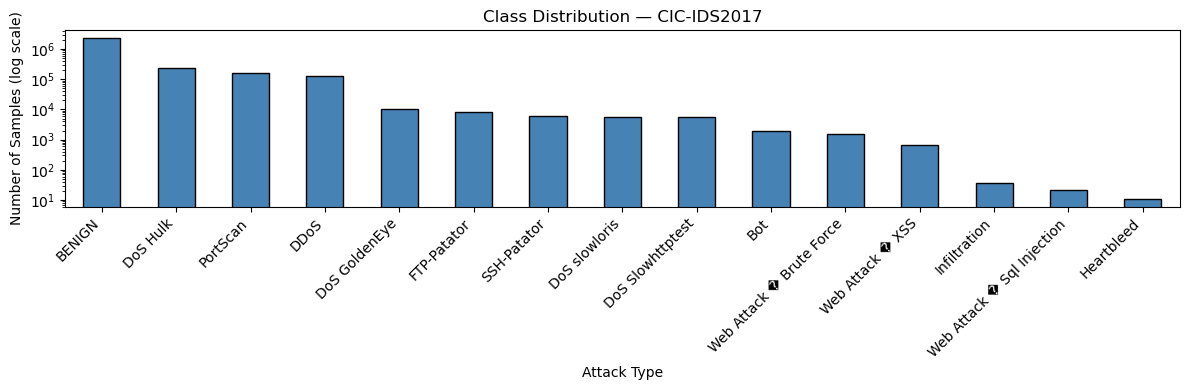

In [5]:
counts.plot(kind='bar', figsize=(12, 4), color='steelblue', edgecolor='black')
plt.title("Class Distribution — CIC-IDS2017")
plt.xlabel("Attack Type")
plt.ylabel("Number of Samples (log scale)")
plt.yscale('log')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

---
## 3. Preprocessing

Network traffic data contains infinity values, physically impossible negatives, redundant features, and near-zero variance columns. Each issue is addressed in sequence.

### 3.1 Handle Infinity & Negative Values

Features such as `Flow Bytes/s` can yield ±Inf when flow duration is near zero. We replace them with NaN and drop those rows, then filter rows with physically impossible negative values.

In [6]:
inf_count = np.isinf(full_df.select_dtypes(include=np.number)).sum().sum()
print(f"Total Infinity values: {inf_count}")

negatives = full_df.select_dtypes(include=np.number).min()
print("\nColumns with negative minimum values:")
print(negatives[negatives < 0])

Total Infinity values: 4376

Columns with negative minimum values:
Flow Duration             -1.300000e+01
Flow Bytes/s              -2.610000e+08
Flow Packets/s            -2.000000e+06
Flow IAT Mean             -1.300000e+01
Flow IAT Max              -1.300000e+01
Flow IAT Min              -1.400000e+01
Fwd IAT Min               -1.200000e+01
Fwd Header Length         -3.221223e+10
Bwd Header Length         -1.073741e+09
Fwd Header Length.1       -3.221223e+10
Init_Win_bytes_forward    -1.000000e+00
Init_Win_bytes_backward   -1.000000e+00
min_seg_size_forward      -5.368707e+08
dtype: float64


In [7]:
full_df.replace([np.inf, -np.inf], np.nan, inplace=True)
full_df.dropna(inplace=True)

initial_shape = full_df.shape[0]

cols_non_negative = [
    'Flow Duration', 'Flow Bytes/s', 'Flow Packets/s',
    'Flow IAT Mean', 'Fwd Header Length', 'min_seg_size_forward'
]
for col in cols_non_negative:
    full_df = full_df[full_df[col] >= 0]

full_df.dropna(inplace=True)
print(f"Rows removed : {initial_shape - full_df.shape[0]}")
print(f"Dataset shape: {full_df.shape}")

Rows removed : 150
Dataset shape: (2827726, 79)


In [8]:
inf_count     = np.isinf(full_df.select_dtypes(include=np.number)).sum().sum()
remaining_neg = full_df.select_dtypes(include=np.number).min()
print(f"Remaining Infinity values: {inf_count}")
print("\nRemaining columns with negative values (acceptable):")
print(remaining_neg[remaining_neg < 0])

Remaining Infinity values: 0

Remaining columns with negative values (acceptable):
Flow IAT Min              -14.0
Fwd IAT Min               -12.0
Init_Win_bytes_forward     -1.0
Init_Win_bytes_backward    -1.0
dtype: float64


### 3.2 Correlation Filter

Feature pairs with |r| > 0.95 are redundant. We keep only one feature from each correlated pair.

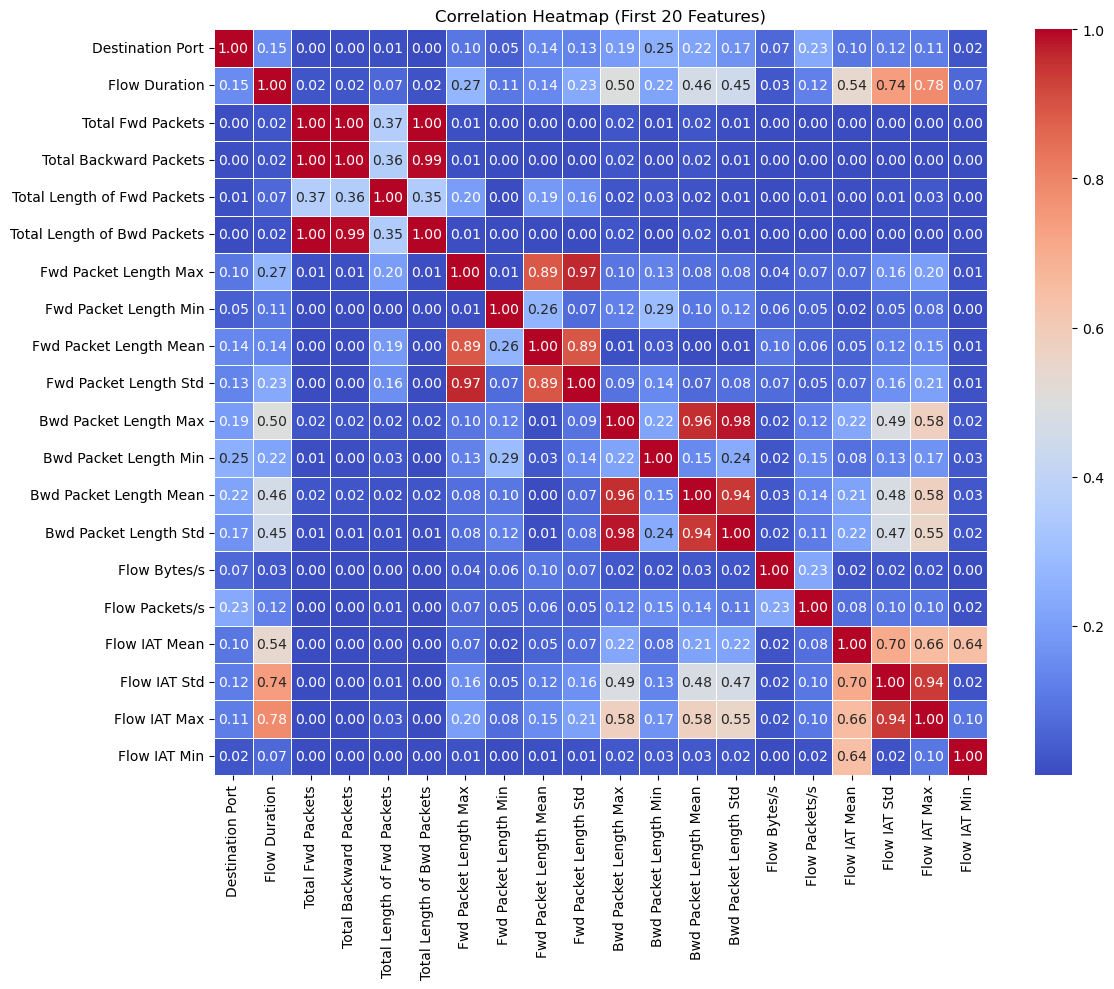

In [9]:
corr_matrix = full_df.corr(numeric_only=True).abs()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix.iloc[:20, :20], annot=True, fmt=".2f",
            cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap (First 20 Features)")
plt.tight_layout()
plt.show()

In [10]:
upper   = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]

full_df_reduced = full_df.drop(columns=to_drop)
print(f"Features reduced from {full_df.shape[1]} to {full_df_reduced.shape[1]}")
print(f"Dropped {len(to_drop)} correlated features.")

Features reduced from 79 to 54
Dropped 25 correlated features.


### 3.3 Feature Scaling — RobustScaler

`RobustScaler` uses the median and IQR, making it resilient to outliers caused by attack traffic spikes (e.g. DDoS).

In [11]:
X = full_df_reduced.drop('Label', axis=1)
y = full_df_reduced['Label']

scaler      = RobustScaler()
X_scaled_df = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

print(f"Scaled feature matrix shape: {X_scaled_df.shape}")

Scaled feature matrix shape: (2827726, 53)


### 3.4 Remove Constant & Quasi-Constant Features

- **Constant** (nunique ≤ 1): carry zero information.
- **Quasi-constant** (same value in >99.5% of rows): removed via `VarianceThreshold`.

In [12]:
# Remove constant features
constant_cols = [col for col in X_scaled_df.columns if X_scaled_df[col].nunique() <= 1]
X_no_constant = X_scaled_df.drop(columns=constant_cols)
print(f"Constant features removed ({len(constant_cols)}): {constant_cols}")

# Remove quasi-constant features
threshold      = 0.005 * (1 - 0.005)
selector       = VarianceThreshold(threshold=threshold)
X_final        = selector.fit_transform(X_no_constant)
final_features = X_no_constant.columns[selector.get_support()]
X_final_df     = pd.DataFrame(X_final, columns=final_features)

print(f"Final feature count: {X_final_df.shape[1]}")

Constant features removed (8): ['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
Final feature count: 43


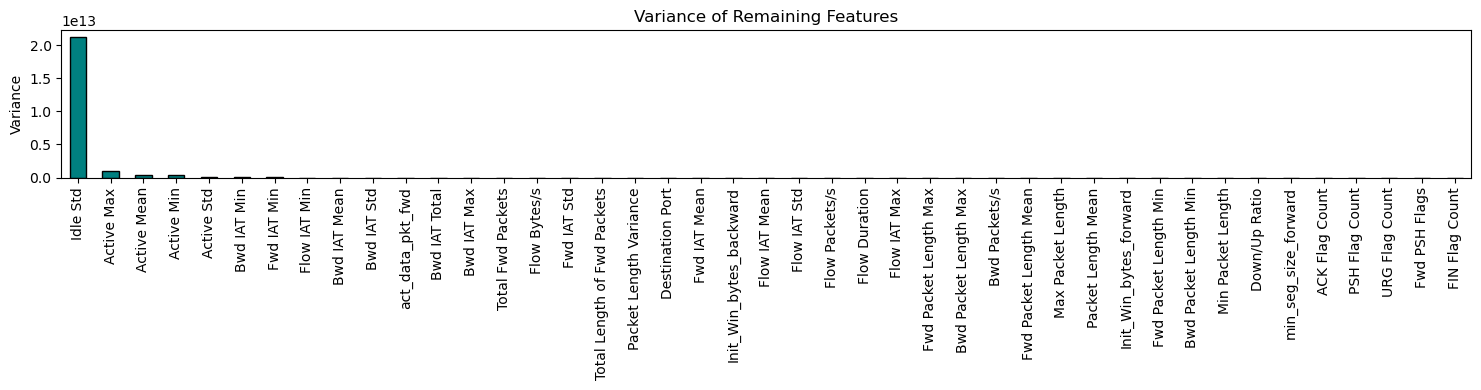

In [13]:
X_final_df.var().sort_values(ascending=False).plot(
    kind='bar', figsize=(15, 4), color='teal', edgecolor='black')
plt.title("Variance of Remaining Features")
plt.ylabel("Variance")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 3.5 Preprocessing Summary

In [14]:
print("=" * 45)
print("        PREPROCESSING SUMMARY")
print("=" * 45)
print(f"  Original features      : {full_df.shape[1] - 1}")
print(f"  After correlation drop : {full_df_reduced.shape[1] - 1}")
print(f"  After constant removal : {X_no_constant.shape[1]}")
print(f"  Final feature count    : {X_final_df.shape[1]}")
print(f"  Total rows retained    : {X_final_df.shape[0]:,}")
print("=" * 45)

        PREPROCESSING SUMMARY
  Original features      : 78
  After correlation drop : 53
  After constant removal : 45
  Final feature count    : 43
  Total rows retained    : 2,827,726


---
## 4. Baseline Classifier

Binary classification: **BENIGN (0) vs. ATTACK (1)**. A shallow Random Forest serves as the black-box target model for the adversarial stage.

### 4.1 Prepare Labels & Train/Validation Split

In [15]:
y_binary = (y != 'BENIGN').astype(int)

X_train, X_val, y_train, y_val = train_test_split(
    X_final_df, y_binary,
    test_size=0.2,
    stratify=y_binary,
    random_state=42
)

print(f"Training set  : {X_train.shape[0]:,} samples")
print(f"Validation set: {X_val.shape[0]:,} samples")
print(f"Attack ratio  : {y_binary.mean():.2%}")

Training set  : 2,262,180 samples
Validation set: 565,546 samples
Attack ratio  : 19.68%


### 4.2 Train Random Forest

In [16]:
baseline = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    n_jobs=-1,
    random_state=42
)
baseline.fit(X_train, y_train)
print("Training complete.")

Training complete.


### 4.3 Evaluation

For intrusion detection, **recall on the attack class** is the most critical metric.

In [17]:
y_pred = baseline.predict(X_val)
print(classification_report(y_val, y_pred, target_names=['BENIGN', 'ATTACK']))

              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00    454235
      ATTACK       1.00      0.98      0.99    111311

    accuracy                           1.00    565546
   macro avg       1.00      0.99      0.99    565546
weighted avg       1.00      1.00      1.00    565546



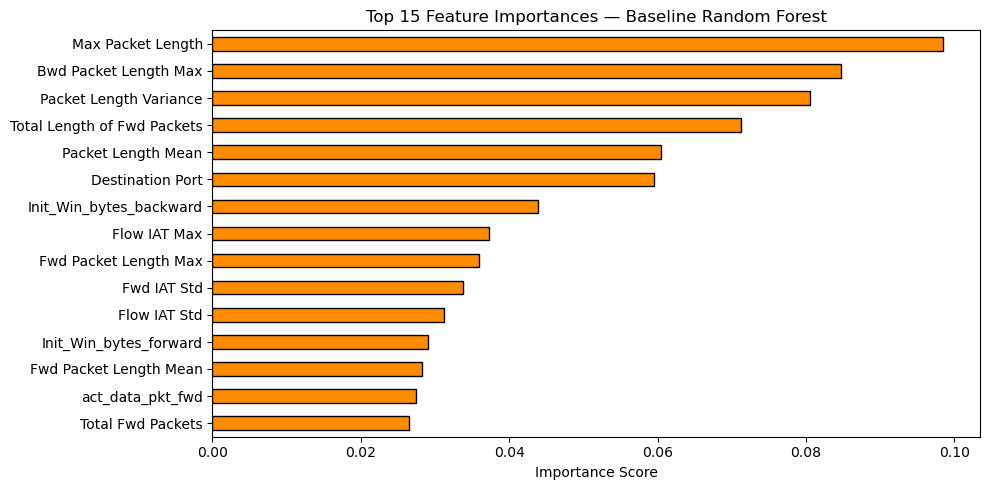

In [18]:
importances = pd.Series(baseline.feature_importances_, index=X_final_df.columns)
importances.sort_values(ascending=False).head(15).plot(
    kind='barh', figsize=(10, 5), color='darkorange', edgecolor='black')
plt.title("Top 15 Feature Importances — Baseline Random Forest")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

---
## 5. Adversarial Attack Generation — AdvGAN

We train a GAN to craft adversarial network flows that preserve attack characteristics while evading the baseline detector. The architecture combines a **Wasserstein GAN (WGAN)** loss with a **black-box evasion loss** that queries the Random Forest directly.

### 5.1 Model Architecture

- **Generator** — produces a bounded perturbation (Tanh) scaled by `epsilon` and a `mask` controlling which features can change.
- **Discriminator** — outputs raw WGAN scores (no sigmoid) to distinguish real from adversarial flows.

In [19]:
input_dim = 43  # final feature count after preprocessing

class AdvGenerator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim, 128), nn.BatchNorm1d(128), nn.ReLU(True),
            nn.Linear(128, 256),       nn.BatchNorm1d(256), nn.ReLU(True),
            nn.Linear(256, input_dim), nn.Tanh()  # perturbation bounded to [-1, 1]
        )

    def forward(self, x, mask, epsilon=0.05):
        return x + self.main(x) * mask * epsilon


class AdvDiscriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim, 256), nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),       nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1)          # raw score — no sigmoid (WGAN)
        )

    def forward(self, x):
        return self.main(x)

### 5.2 Training Loop

Two losses drive the generator:
1. **WGAN loss** — makes adversarial flows indistinguishable from real attack traffic.
2. **Black-box evasion loss** — queries the RF for P(BENIGN) and penalises samples still classified as attacks. `alpha` balances the two objectives.

In [20]:
feature_names = X_train.columns

def train_advgan(generator, discriminator, target_model, dataloader,
                 epochs=50, alpha=10.0):
    opt_G = optim.Adam(generator.parameters(),     lr=1e-4, betas=(0.5, 0.9))
    opt_D = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.9))
    generator.train(); discriminator.train()

    for epoch in range(epochs):
        for real, _ in dataloader:
            real = real.to(device)

            # ── Discriminator ──────────────────────────────────────────────
            opt_D.zero_grad()
            fake   = generator(real, mask).detach()
            loss_D = -torch.mean(discriminator(real)) + torch.mean(discriminator(fake))
            loss_D.backward(); opt_D.step()

            # ── Generator ──────────────────────────────────────────────────
            opt_G.zero_grad()
            adv      = generator(real, mask)
            loss_gan = -torch.mean(discriminator(adv))

            # Black-box query: P(BENIGN) from the Random Forest
            with torch.no_grad():
                adv_df = pd.DataFrame(adv.detach().cpu().numpy(), columns=feature_names)
                p_benign = torch.tensor(
                    target_model.predict_proba(adv_df)[:, 0],
                    device=device, dtype=torch.float32
                )

            loss_adv = torch.mean(1.0 - p_benign)
            (loss_gan + alpha * loss_adv).backward(); opt_G.step()

        print(f"Epoch [{epoch+1:>2}/{epochs}]  "
              f"Loss D: {loss_D.item():.4f}  |  Loss adv: {loss_adv.item():.4f}")

### 5.3 Data Preparation

The GAN trains exclusively on attack samples. The `mask` vector controls feature mutability (1 = mutable, 0 = immutable).

In [21]:
X_attacks_only   = X_train.iloc[y_train.to_numpy() == 1]
X_attacks_tensor = torch.tensor(X_attacks_only.to_numpy(), dtype=torch.float32)
y_attacks_tensor = torch.ones(len(X_attacks_tensor), dtype=torch.float32)

attack_loader = DataLoader(
    TensorDataset(X_attacks_tensor, y_attacks_tensor),
    batch_size=64, shuffle=True, drop_last=True
)

# All features mutable — refine with domain knowledge if needed
mask = torch.ones(X_attacks_tensor.shape[1], dtype=torch.float32).to(device)

print(f"Attack samples: {len(X_attacks_only):,}  |  Batches/epoch: {len(attack_loader)}")

Attack samples: 445,245  |  Batches/epoch: 6956


### 5.4 Train AdvGAN

In [22]:
generator     = AdvGenerator(input_dim).to(device)
discriminator = AdvDiscriminator(input_dim).to(device)

train_advgan(generator, discriminator, baseline, attack_loader, epochs=30)

Epoch [ 1/30]  Loss D: 0.0001  |  Loss adv: 0.6621
Epoch [ 2/30]  Loss D: 0.0029  |  Loss adv: 0.6182
Epoch [ 3/30]  Loss D: 0.0000  |  Loss adv: 0.6628
Epoch [ 4/30]  Loss D: 0.0000  |  Loss adv: 0.6461
Epoch [ 5/30]  Loss D: 0.0000  |  Loss adv: 0.7070
Epoch [ 6/30]  Loss D: 0.0015  |  Loss adv: 0.7015
Epoch [ 7/30]  Loss D: 0.0000  |  Loss adv: 0.6812
Epoch [ 8/30]  Loss D: 0.0000  |  Loss adv: 0.7319
Epoch [ 9/30]  Loss D: 0.0010  |  Loss adv: 0.7335
Epoch [10/30]  Loss D: 0.0010  |  Loss adv: 0.7133
Epoch [11/30]  Loss D: 0.0003  |  Loss adv: 0.6743
Epoch [12/30]  Loss D: 0.0007  |  Loss adv: 0.6573
Epoch [13/30]  Loss D: 0.0014  |  Loss adv: 0.5806
Epoch [14/30]  Loss D: -0.0012  |  Loss adv: 0.6972
Epoch [15/30]  Loss D: 0.0022  |  Loss adv: 0.6560
Epoch [16/30]  Loss D: 0.0002  |  Loss adv: 0.6377
Epoch [17/30]  Loss D: -0.0010  |  Loss adv: 0.7163
Epoch [18/30]  Loss D: 0.0010  |  Loss adv: 0.6412
Epoch [19/30]  Loss D: 0.0000  |  Loss adv: 0.7754
Epoch [20/30]  Loss D: 0.0000

### 5.5 Evasion Evaluation

**Evasion Success Rate (ESR)** = percentage of adversarial attack samples misclassified as BENIGN.

In [23]:
def test_evasion(gen, target_model, test_df, labels, mask_tensor,
                 epsilon=0.05, tag=""):
    gen.eval().to(device)
    mask_tensor = mask_tensor.to(device)

    real = torch.tensor(
        test_df.values[labels.values == 1], dtype=torch.float32
    ).to(device)

    with torch.no_grad():
        adv_np = gen(real, mask_tensor, epsilon=epsilon).cpu().numpy()

    preds    = target_model.predict(adv_np)
    evasions = np.sum(preds == 0)
    esr      = evasions / len(adv_np) * 100

    print(f"{'─'*42}")
    print(f"  Adversarial Evaluation {tag}")
    print(f"  Attack samples tested : {len(adv_np):,}")
    print(f"  Successful evasions   : {evasions:,}")
    print(f"  ESR                   : {esr:.2f}%")
    print(f"{'─'*42}")
    return adv_np

In [24]:
adv_samples = test_evasion(generator, baseline, X_val, y_val, mask,
                           tag="— Baseline Model")

──────────────────────────────────────────
  Adversarial Evaluation — Baseline Model
  Attack samples tested : 111,311
  Successful evasions   : 48,602
  ESR                   : 43.66%
──────────────────────────────────────────


c:\Users\O M E N\anaconda3\envs\cuda_test\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


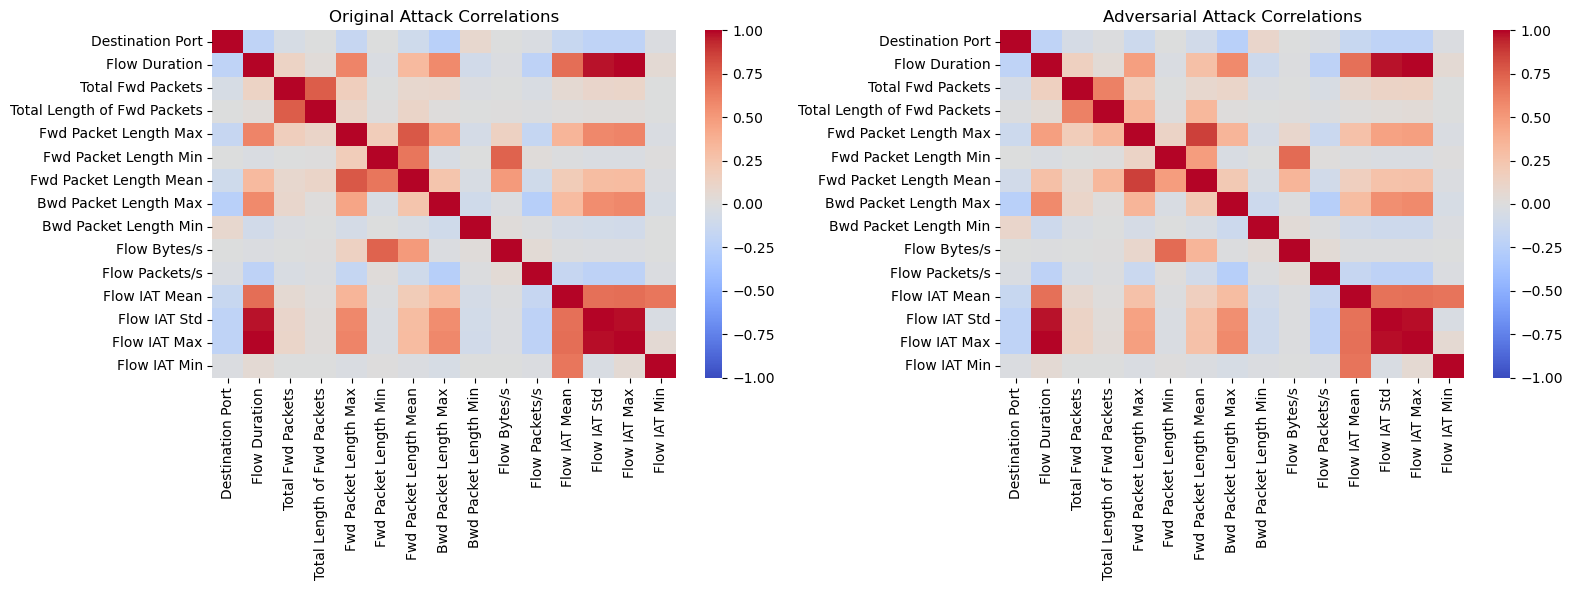

In [25]:
features_to_plot = list(X_final_df.columns[:15])
real_corr = X_train.iloc[y_train.values == 1][features_to_plot].corr()
adv_corr  = pd.DataFrame(adv_samples[:, :15], columns=features_to_plot).corr()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(real_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1, ax=ax1)
ax1.set_title("Original Attack Correlations")
sns.heatmap(adv_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1, ax=ax2)
ax2.set_title("Adversarial Attack Correlations")
plt.tight_layout(); plt.show()

### 5.6 Perturbation Analysis

Which features did the GAN modify the most to achieve evasion?

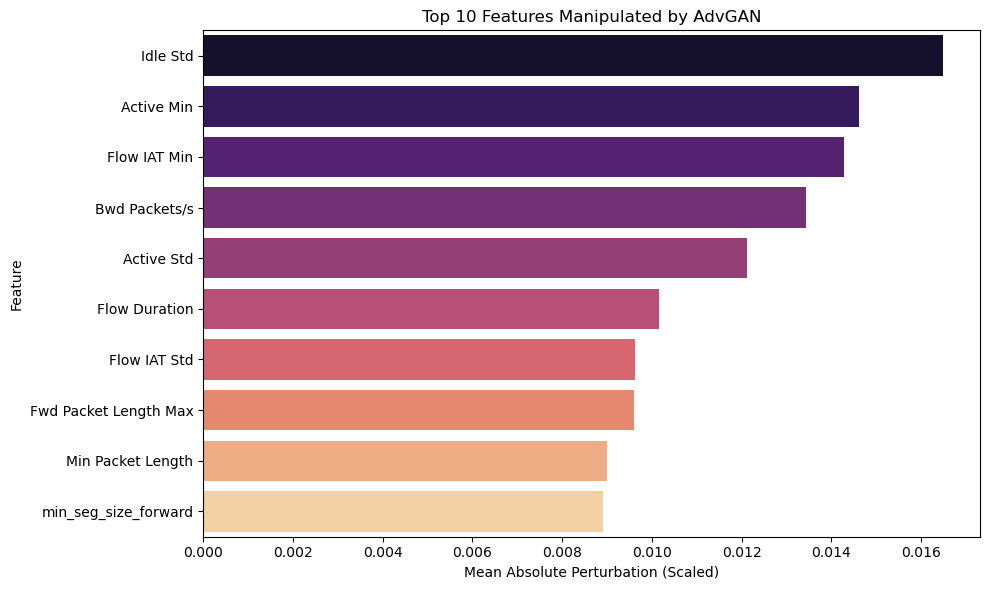

Top 5 most manipulated features:
      Feature  Mean Perturbation
     Idle Std           0.016488
   Active Min           0.014613
 Flow IAT Min           0.014271
Bwd Packets/s           0.013427
   Active Std           0.012112


In [26]:
real_np   = X_val.values[y_val.values == 1]
mean_diff = np.mean(np.abs(adv_samples - real_np), axis=0)

perturb_df = pd.DataFrame({
    'Feature': X_final_df.columns,
    'Mean Perturbation': mean_diff
}).sort_values('Mean Perturbation', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=perturb_df.head(10), x='Mean Perturbation', y='Feature',
            hue='Feature', palette='magma', legend=False)
plt.title("Top 10 Features Manipulated by AdvGAN")
plt.xlabel("Mean Absolute Perturbation (Scaled)")
plt.tight_layout(); plt.show()

print("Top 5 most manipulated features:")
print(perturb_df.head(5).to_string(index=False))

---
## 6. Adversarial Retraining

We augment the training set with adversarial samples and retrain the classifier to reduce the ESR to near 0%.

### 6.1 Augment Training Data

In [27]:
adv_df         = pd.DataFrame(adv_samples, columns=X_final_df.columns)
adv_labels     = pd.Series([1] * len(adv_samples))

X_train_robust = pd.concat([X_train, adv_df],     ignore_index=True)
y_train_robust = pd.concat([y_train, adv_labels], ignore_index=True)

print(f"Original training size   : {len(X_train):,}")
print(f"Adversarial samples added: {len(adv_samples):,}")
print(f"Augmented training size  : {len(X_train_robust):,}")

Original training size   : 2,262,180
Adversarial samples added: 111,311
Augmented training size  : 2,373,491


### 6.2 Train Robust Classifier

In [28]:
robust_baseline = RandomForestClassifier(
    n_estimators=50, max_depth=10, n_jobs=-1, random_state=42
)
robust_baseline.fit(X_train_robust, y_train_robust)
print("Robust model trained.")

Robust model trained.


### 6.3 Re-evaluate Evasion Rate

The same adversarial samples are run against the retrained model.

In [29]:
_ = test_evasion(generator, robust_baseline, X_val, y_val, mask,
                 tag="— Robust Model")

──────────────────────────────────────────
  Adversarial Evaluation — Robust Model
  Attack samples tested : 111,311
  Successful evasions   : 0
  ESR                   : 0.00%
──────────────────────────────────────────


c:\Users\O M E N\anaconda3\envs\cuda_test\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


---
## 7. Model Persistence

Save all trained components so the pipeline can be resumed without retraining. 
The scaler **must** be saved alongside the models — inference will fail without it.

### 7.1 Save Models

In [ ]:
import joblib

os.makedirs('models', exist_ok=True)

# GAN
torch.save(generator.state_dict(),     'models/advgan_generator.pth')
torch.save(discriminator.state_dict(), 'models/advgan_discriminator.pth')

# Random Forest & Scaler
joblib.dump(baseline,                  'models/rf_baseline.joblib')
joblib.dump(robust_baseline,           'models/rf_robust_baseline.joblib')
joblib.dump(scaler,                    'models/robust_scaler.joblib')
joblib.dump(list(X_final_df.columns),  'models/feature_columns.joblib')

print("All models saved successfully.")

### 7.2 Load Models

Use this cell to restore the full pipeline in a new session without rerunning training.

In [ ]:
# Restore sklearn components
scaler          = joblib.load('models/robust_scaler.joblib')
baseline        = joblib.load('models/rf_baseline.joblib')
robust_baseline = joblib.load('models/rf_robust_baseline.joblib')
feature_cols    = joblib.load('models/feature_columns.joblib')

# Restore GAN generator (AdvGenerator class must be defined above)
generator = AdvGenerator(input_dim=43)
generator.load_state_dict(
    torch.load('models/advgan_generator.pth', weights_only=True)
)
generator.eval()

print("All components reloaded and ready.")